
#Assignment Set 2

by **Amir Mehrpanah** for Deep Learing Course at Data Science Center, SBU



In [ ]:
#@title Downloading The Data
import urllib.request
import os
import ast 
import idx2numpy
import glob 

print('Downloading fashion MNIST...')

urls = ['http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz',
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz',
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz',
        'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz']
for item in urls:
    urllib.request.urlretrieve(item, 'data/fashion-mnist/'+item.split('/')[-1])

!gunzip data/fashion-mnist/*.gz
!ls data/fashion-mnist/*

In [34]:
#@title Manual Data Injection
files = glob.glob('data/fashion-mnist/*-ubyte')

print(files)
x_test = idx2numpy.convert_from_file(files[3]) # test images
x_test = x_test.reshape(10000,28,28,1)
print(x_test.shape)
y_test = idx2numpy.convert_from_file(files[2]) # test labels
print(y_test.shape)

x_ = idx2numpy.convert_from_file(files[1]) # train images
x_ = x_.reshape(60000,28,28,1)
print(x_.shape)
y_ = idx2numpy.convert_from_file(files[0]) # train labels
print(y_.shape)

x_train, x_val, y_train, y_val = train_test_split(x_, y_, test_size= 0.2)

x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

['data/fashion-mnist/train-labels-idx1-ubyte', 'data/fashion-mnist/train-images-idx3-ubyte', 'data/fashion-mnist/t10k-labels-idx1-ubyte', 'data/fashion-mnist/t10k-images-idx3-ubyte']
(10000, 28, 28, 1)
(10000,)
(60000, 28, 28, 1)
(60000,)


In [ ]:
#@title Single Hidden Layer NNs **Without** Output One-Hot Encoding
#@markdown by using sparse categorical cross entropy there is no need to one-hot encode the true lables and from_logits set to true thus the model doesnt have any normalization layer.
epochs =  20#@param {type:"integer"}
max_params = 20000#@param {type: "integer"}
verbose =  2#@param {type:"number"}

max_idx=0
while max_params > 784*max_idx+max_idx+10*(max_idx+1):
    max_idx+=1

mdl_pool = {}
for i in range(2,max_idx): 
    name = "clf_1l"+str(i)
    input = keras.Input(shape=(784,))
    x = layers.Dense(i, activation="relu")(input)
    output = layers.Dense(10)(x)
    model = keras.Model(inputs=input, outputs=output, name=name)
    
    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer='Adam',
                  metrics=['accuracy'])
    mdl_pool[name] = {'params':784*i+i+10*(i+1),
                     'nolayers':1}
    if(verbose):
        print('model no.',i,'summary')
        model.summary()
    mdl_pool[name]['history'] = model.fit(x = x_train, y = y_train,
                        batch_size=64, epochs=epochs,
                        verbose=verbose,validation_data=(x_val,y_val),
                        validation_batch_size = 32).history


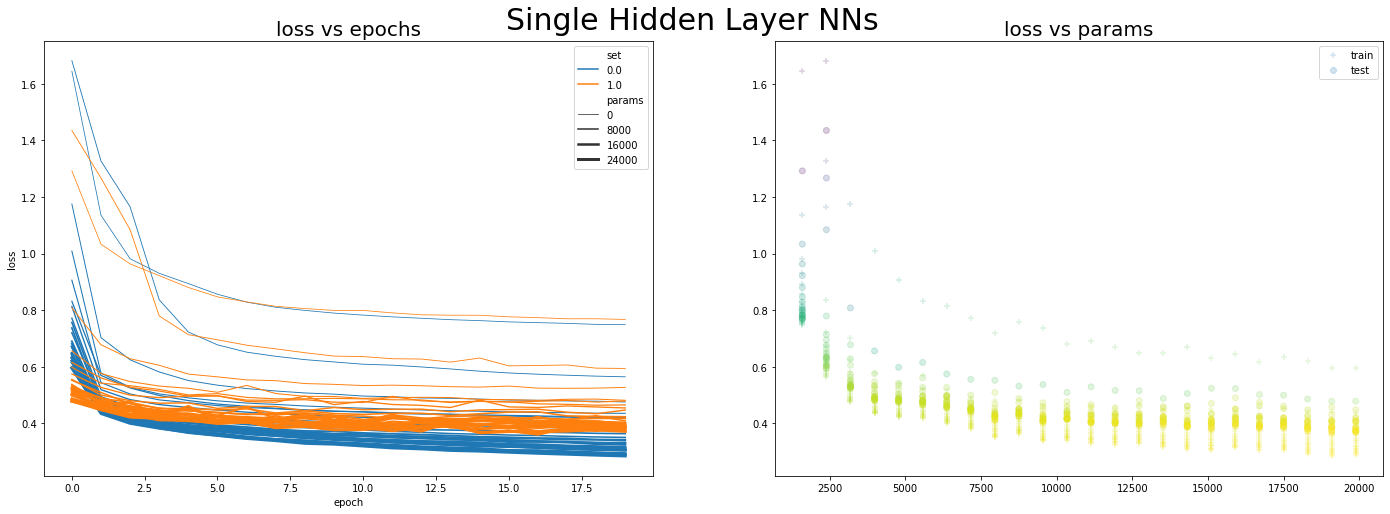

In [ ]:
#@title Analyse Performances
#@markdown There is a considerable improvement in the obtainable loss function both for train and  
#@markdown test sets as long as the number of trainable parameters is less than 7.5k
#@markdown but there is little change in loss after that number for test set. lighter
#@markdown colors indicate the higher accuracy.
fig = plt.gcf()
fig.set_size_inches(24, 8)
plt.figtext(.5,.9,'Single Hidden Layer NNs', fontsize=30, ha='center')
palette = sns.color_palette("mako_r", max_idx)
ax = plt.subplot(1,2,1)
ax.set_title('loss vs epochs',fontsize= 20) 
sns.lineplot(data=records,
             x='epoch', y='loss',hue='set',size='params')
ax = plt.subplot(1,2,2)
ax.set_title('loss vs params',fontsize= 20)
train = records['set'] == 0
plt.scatter(x=records[train]['params'], y=records[train]['loss'],
            alpha=.2,c=records[train]['accuracy'],
            label='train',marker='+')
plt.scatter(x=records[~train]['params'], y=records[~train]['loss'],
            alpha=.2,c=records[train]['accuracy'],
            label='test',marker='o')
plt.legend()
plt.show()
with open('mdls/clf_1l.log','w') as f:
    json.dump(mdl_pool,f)

In [ ]:
#@title Multi Hidden Layer NNs **Without** Output One-Hot Encoding
#@markdown by using sparse categorical cross entropy there is no need to one-hot encode the true lables and from_logits set to true thus the model doesnt have any normalization layer.
epochs =  20#@param {type:"integer"}
max_layers = 7#@param {type: "integer"}
max_params = 20000#@param {type: "integer"}
verbose =  2#@param {type:"number"}

counter = 0
mdl_pool = {}
for i in range(2,max_layers): 
    finished= False
    architecture = np.ones(i)+1
    while True:
        for j,_ in enumerate(architecture):
            if architecture[j] == 30:
                architecture[j] = 2
                if j+1 == i:
                    finished = True
                    break
                architecture[j+1]+=1
        if finished:
            break

        name = "clf_{}l".format(i)+str(counter)
        
        input = keras.Input(shape=(784,))
        x = layers.Dense(architecture[0], activation="relu")(input)
        for k in range(1,i):
            x = layers.Dense(architecture[k], activation="relu")(x)
        output = layers.Dense(10)(x)
        model = keras.Model(inputs=input, outputs=output, name=name)
        model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    optimizer='Adam',
                    metrics=['accuracy'])
        
        params = model.count_params()
        architecture[0]+=1

        if params > max_params:
            if(verbose>2):
                print(architecture,'skiped params > max_params')
            continue

        counter+=1
        if(verbose > 0):
            print('\rmodel number',counter,architecture,end='')
        file_name = 'mdls/clf_'+str(i)+'l_'+str(counter)+'.log'
        if os.path.isfile(file_name):
            if(verbose>2):
                print(architecture,params,file_name,'file already exists')
            continue

        mdl_pool[name] = {'params':params,
                        'nolayers':1}
        if(verbose>1):
            model.summary()
        mdl_pool[name]['history'] = model.fit(x = x_train, y = y_train,
                        batch_size=64, epochs=epochs,
                        verbose=verbose,validation_data=(x_val,y_val),
                        validation_batch_size = 32).history
        keras.backend.clear_session()
        with open(file_name,'w') as f:
            json.dump(mdl_pool,f)
        mdl_pool = {}
        

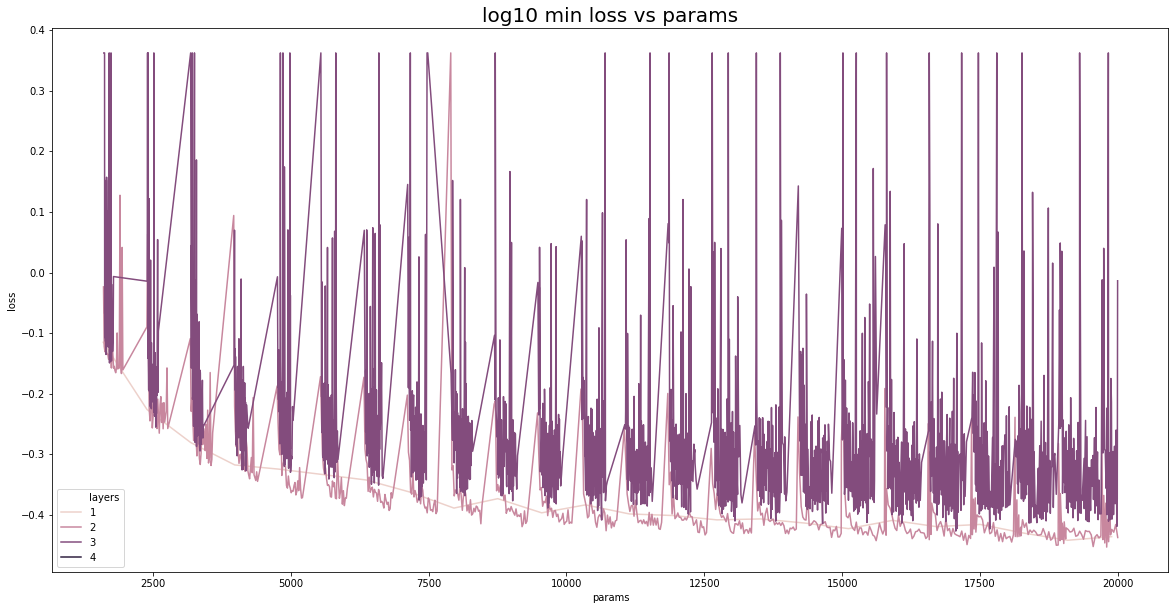

In [ ]:
#@title Analyse Performances
#@markdown We compute the minimum test loss for each model grouped by layers and params.
#@markdown There is a no guarantee that increasing the depth of the network will 
#@markdown always improve network performance. Here we see that a two-layer nn 
#@markdown performs better on average in most parameters.
fig = plt.gcf()
fig.set_size_inches(20, 10)
temp = records.where(
    records['set']=='test').groupby(['params',
                                     'layers'])['loss'].min().reset_index()
ax = plt.subplot(1,1,1)
ax.set_title('log10 min loss vs params',fontsize= 20)

sns.lineplot(x=temp['params'], y=np.log10(temp['loss']),
             hue=temp['layers'])

plt.show()

In [52]:
#@title Multi Hidden Layer CNNs **Without** Output One-Hot Encoding
#@markdown Training a convolutional neural network to compare the performance
name = 'conv_clf_1'

input = keras.Input(shape=(28,28,1))
x = layers.Conv2D(8,4,activation="relu")(input)
x = layers.Conv2D(16,4,activation="relu")(x)
x = layers.MaxPool2D()(x)
output = layers.Dense(10,'relu')(layers.Flatten()(x))
model = keras.Model(inputs=input, outputs=output, name=name)
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            optimizer='Adam',
            metrics=['accuracy'])
model.summary()

Model: "conv_clf_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 25, 25, 8)         136       
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 22, 22, 16)        2064      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 11, 11, 16)        0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 1936)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 10)                19370     
Total params: 21,570
Trainable params: 21,570
Non-trainable params: 0
____________________________________________________

In [ ]:
epochs =  20#@param {type:"integer"}
verbose =  1#@param {type:"number"}
model.fit(x = x_train, y = y_train,
                        batch_size=64, epochs=epochs,
                        verbose=verbose,validation_data=(x_val,y_val),
                        validation_batch_size = 32)

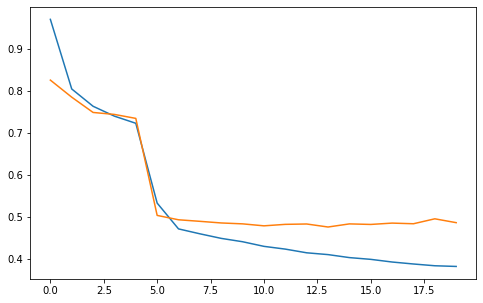

In [54]:
#@title Training History
#@markdown Training the model for more than 6 epochs has led to overfitting
plt.figure(figsize=(8,5))
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])

In [55]:
#@title Evaluating on testing data
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.4958 - accuracy: 0.8209


[0.49582725763320923, 0.820900022983551]